
# Float vertical position control, ensta prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

WOA water profile at lon=-50, lat=40


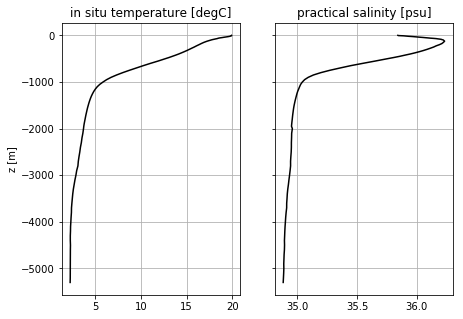

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-100.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='ENSTA')

# compute compressibility
gamma=compute_gamma(f.r,.005,material='polycarbonat')
print('Float compressibility = %e /dbar \n' %(gamma))
f.gamma=gamma

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Float compressibility = 9.300000e-05 /dbar 

131.8 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.79 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte     = 1.02e+09 kg.cm^3   - float constant density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 25.00 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 114.46 cm^3      - present volume addition
  lead  = 1.75 cm        - screw lead
  tick_per_t

In [4]:
rho_eq = rho_w[iz]
temp_eq = temp[iz]
p_eq=20
f.piston_update_vol(f.piston.vol_max)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))
f.piston_update_vol(f.piston.vol_min)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))

20.597707653301427
-3.9710755106480065


In [5]:
# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+20.))
vmax = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
f.piston.update_d(f.piston.d+.001)
f.piston_update_vol()
print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=-2.2e+00 cm^3  
z equilibrium = -20.0m
z equilibrium after 1 mm piston displacement = -24.4m


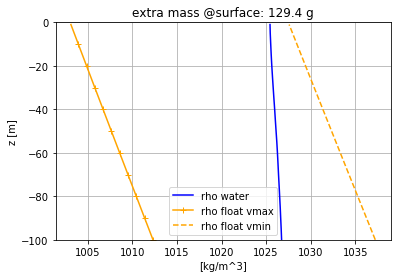

In [6]:
# show densities
plot_float_density(z, f, w)

---

## From the surface down to a target level

In [7]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600, -25., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=2.2e-01 m^2/s, fmin/m= -4.5e-01 m^2/s, wmax= 386.3 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 1.3e+03 cm/s, fmin/m= -2.7e+03 cm/s


In [8]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-10., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control)

 ctrl: tau = 2.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
Start time stepping for 5 min ...
... time stepping done


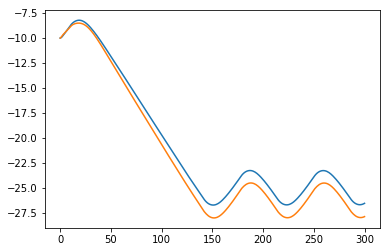

In [9]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.log.t,f.log.z)
x_hat = np.array(f.x_kalman)
ax.plot(f.t_kalman,-x_hat[:,1])

In [18]:
[f.v, -f.z]

[-6.9648263099077926e-06, 23.779611932489416]

In [16]:
x0 = f.kalman.x_hat
gamma0 = f.kalman.gamma
print(x0)
print(gamma0)

[ 9.45355213e-01  2.52595768e+01 -1.81620863e-04  1.78964425e-04]
[[1.38734996e-14 9.53055638e-23 0.00000000e+00 0.00000000e+00]
 [9.53055638e-23 1.61803399e-20 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e-20 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e-20]]


In [ ]:
f.kalman.x_hat = x0
f.kalman.gamma = gamma0

In [17]:
print(f.kalman.x_hat)
f.kalman.update_kalman(0., f.z, f.v)
print(f.kalman.x_hat)

[ 9.45355213e-01  2.52595768e+01 -1.81620863e-04  1.78964425e-04]
[ 9.45439871e-01  2.52848699e+01 -1.83775059e-04  1.78964425e-04]


In [26]:
y = f.kalman.gen_obs(f.z, f.v)
y

[23.779594729549178, -0.00018592925403242532]

In [24]:
f.kalman.kalman_correc(x0,gamma0,y)

(array([ 9.39967633e-01,  2.43449094e+01, -1.83775056e-04,  1.78964425e-04]),
 array([[1.38734996e-14, 3.64034861e-23, 0.00000000e+00, 0.00000000e+00],
        [3.64034861e-23, 6.18033989e-21, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-21, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-20]]))

In [20]:
f.kalman.gamma_beta

array([[1.e-20, 0.e+00],
       [0.e+00, 1.e-20]])

In [36]:
f.kalman.C@np.array(y)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)

In [30]:
def kalman_correc(kalman, x0,gamma0,y):
    C = kalman.C
    S = C @ gamma0 @ C.T + kalman.gamma_beta
    K = gamma0 @ C.T @ np.linalg.inv(S)
    ytilde = np.array(y) - C @ x0
    Gup = (np.eye(len(x0))-K @ C) @ gamma0
    xup = x0 + K@ytilde
    return xup, Gup, ytilde, K

In [31]:
kalman_correc(f.kalman, x0,gamma0,y)

(array([ 9.39967563e-01,  2.43448976e+01, -1.83775059e-04,  1.78964425e-04]),
 array([[1.38734996e-14, 3.64034861e-23, 0.00000000e+00, 0.00000000e+00],
        [3.64034861e-23, 6.18033989e-21, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.00000000e-21, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e-20]]),
 array([-1.47998207e+00, -4.30839106e-06]),
 array([[0.00364035, 0.        ],
        [0.61803399, 0.        ],
        [0.        , 0.5       ],
        [0.        , 0.        ]]))

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman,-x_hat[:,3])

In [ ]:
x_hat.shape

In [ ]:
# plot log
plot_log(f,z_target=z_target)

---

## Oscillations around a fixed level

In [ ]:
z_target = lambda t: -25+10.*np.sin(2.*np.pi/600.*t)

In [ ]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1.,
            usepiston=True, z_target=z_target, ctrl=control)

In [ ]:
plot_log(f,z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [ ]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*20.)*t)
z_target = lambda t: -25.+t*0.

In [ ]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

In [ ]:
plot_log(f, z_target=z_target, eta=eta)

---

## Moving isopycnals without control

In [ ]:
iz = np.argmin(np.abs(z+25.))
v = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
f.time_step(w, T=1800., dt_step=.1, dt_store=1., z=-25., w=0., v=v, usepiston=False, eta=eta)

In [ ]:
plot_log(f, z_target=z_target, eta=eta)